In [1]:


import numpy             as np
import matplotlib.pyplot as plt
from matplotlib          import rc 
from tqdm import tqdm
import matplotlib.animation as animation
import scipy.integrate as integrate

$$ P(A/B) = \frac{P(B/A)P(A)}{P(B)}  $$

$P(A)$ es el prior.  (Hipótesis (Modelos en general)) 

$P(B/A)$ es la probabilidad de $B$ dada la hipótesis $A$. (Likelihood)

$P(B)$ Evidencia, no calculable en general (factor de normalización)

$P(A/B)$ es la probabilidad posterior.

$$ P(A/B) \propto P(B/A)P(A)  $$

Esto puede verse como un proceso de actualización de las probabilidades dada la evidencia!

# Miremos el ejemplo clásico de un moneda y aprendamos de cada experimento.

$$ 0 \le H \le 1 $$

donde 0 son sellos
donde 1 son caras

Tenemos varias hipotésis:

$$ 0 < H < 0.01 $$
$$ 0.49 < H < 0.51 $$

Definamos nuestro prior:

$$P(H) = \left\{ \begin{array}{lc}
1 & 0 \le H \le 1\\
0 & \text{Otro caso} \\
\end{array}
\right.  $$ 

Definamos nuestro Likelihood

$$ P(D/H) \propto H^{R}(1-H)^{N-R}  $$

N = Número de Lanzamientos.
R = Cuántos de los Lanzamientos son sellos.
N-R = Número de Caras

In [2]:
def pi(H):
    return np.piecewise(H, [H>=0. and H<=1., H>1. and H<0.], [lambda H:1,lambda H:0.])

pi = np.vectorize(pi)

In [3]:
print(pi(0.5))

1.0


In [4]:
# Explorar el espacio de parametros

Npoints = 100
H = np.linspace(0.,1.,Npoints)

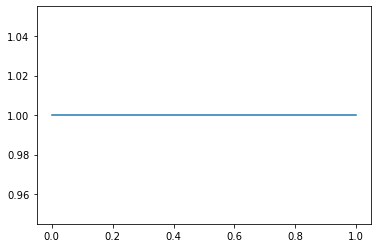

In [5]:
plt.plot(H,pi(H))

In [6]:
# Definamos el Likelihood

def Likelihood(H,R,N):
    return H**R*(1-H)**(N-R)

In [7]:
R_ = 3
N_ = 5

Text(0, 0.5, '$\\mathcal{L}(D/H)$')

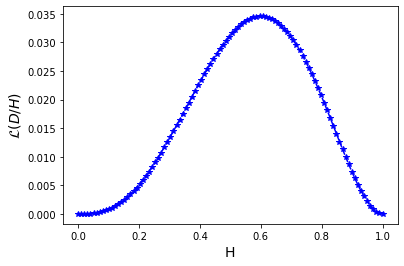

In [8]:
plt.plot(H,Likelihood(H,R_,N_),'b*--')
plt.xlabel('H',fontsize=14)
plt.ylabel(r'$\mathcal{L}(D/H)$',fontsize=14)

In [9]:
def PosteriorF(H):
    return Likelihood(H,R_,N_)*pi(H)

In [10]:
# Necesitamos la normalizacion

a, b = H[0],H[-1]
Pintegral = integrate.quad(PosteriorF,a,b)
print(Pintegral[0])

0.016666666666666666


Text(0, 0.5, '$\\mathcal{L}(D/H)\\times \\pi(H)$')

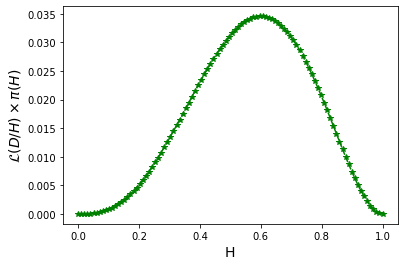

In [11]:
plt.plot(H,PosteriorF(H),'g*--')
plt.xlabel('H',fontsize=14)
plt.ylabel(r'$\mathcal{L}(D/H)\times \pi(H)$',fontsize=14)

In [12]:
Lmax = np.argmax(Likelihood(H,R_,N_)*pi(H))

Hmax = H[Lmax]
print(Hmax)

0.595959595959596


# Muestrear la posterior con MCMC

In [13]:
def Metropolis(H0_,WidthSteps,NSteps):
    
    # Diccionario para animar
    ArrayMC = {}
    
    MCMC = np.array([])
    
    burn = 5000
    
    j = 0
    
    for i in tqdm(range(int(NSteps))):
        
        # Present
        P0 = PosteriorF(H0_)
        
        Hn_ = H0_ + WidthSteps*np.random.uniform(-1.,1.)
        
        # Futuro
        
        Pn = PosteriorF(Hn_)
        
        alpha = Pn/P0
        
        r = np.random.rand()
        
        if np.minimum(1,alpha) > r:
            
            H0_ = Hn_
            
            if i > burn:
                MCMC = np.append(MCMC,Hn_)
                
                if(i%100 == 0):
                    ArrayMC[j] = MCMC
                    j+=1
                    
        else:
            
            if i > burn:
                MCMC = np.append(MCMC,H0_)
                
                
                if(i%100 == 0):
                    ArrayMC[j] = MCMC
                    j+=1
        
        
    return MCMC, ArrayMC

In [14]:
MCMC, ArrayMC = Metropolis(0.9,0.2,5e4)

100%|██████████| 50000/50000 [00:12<00:00, 3915.26it/s]


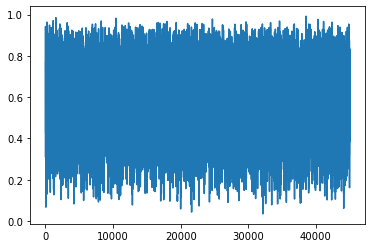

In [15]:
plt.plot(MCMC)

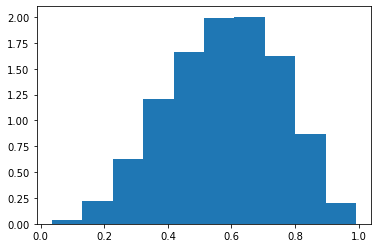

In [16]:
plt.hist(MCMC,density=True)
plt.show()

In [17]:
mean = np.percentile(MCMC,50)
sigmaleft = np.percentile(MCMC,16)
sigmaright = np.percentile(MCMC,84)

print(mean-sigmaleft,mean,sigmaright-mean)

0.1966782524974554 0.5848748111264209 0.1769241383269553


$$ \hat{H} = 0.58_{-0.18}^{+0.17} $$

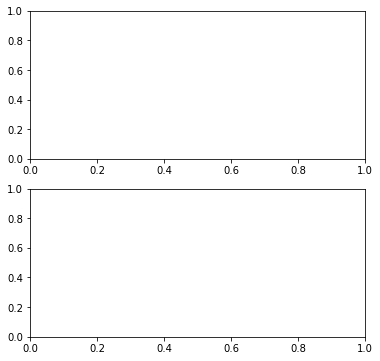

In [18]:
# Zona de animación

Nframes = len(ArrayMC) 

fig = plt.figure(figsize=(6,6))

ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

def init():
    
    ax1.set_ylim(0.,1.)

In [19]:
def animate(i):
    
    H1, bines = np.histogram(ArrayMC[i], bins=H)
    w = np.diff(bines)
    
    NormH1 = H1 / (np.sum(H1*w)) * Pintegral[0]
    
    plot = ax1.clear()
    plot = ax2.clear()
    init()
    
    ax1.plot(ArrayMC[i], c='k',marker='.',alpha=0.3)
    
    ax2.plot(H,PosteriorF(H),color='r',marker='.')
    ax2.bar(bines[:-1], NormH1, width=w,ec='k')
    
    return plot

In [20]:
Animation = animation.FuncAnimation(fig,animate,frames=Nframes,init_func=init)

In [21]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800 )
#Animation.save( 'MCMC.mp4', writer=writer )